In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.model_selection import KFold

sns.set()
sns.set_style('white')

# Introduction

An earthquake (also known as a quake, tremor or temblor) is the shaking of the surface of the Earth resulting from a sudden release of energy in the Earth's lithosphere that creates seismic waves. There are three main types of fault, all of which may cause an interplate earthquake: normal, reverse (thrust), and strike-slip; Strike-slip faults are steep structures where the two sides of the fault slip horizontally past each other.
<img src="intro-pics/earthquake_dynamics.gif"  width="350" />

Interferometric synthetic aperture radar (InSAR) is a radar technique used in geophysical remote sensing. This  method uses two or more synthetic aperture radar (SAR) images to map the surface deformation, using differences in the phase of the waves returning to the satellite. The technique can  measure millimeter scale changes in deformation over spans of days to years.

<img src="intro-pics/how_insar_works.jpg"  width="500" />

In geophysics, what we do is to figure out how much the fault dislocates ("fault slip") due to an earthquake using the surface deformation data.
The slip on the fault is not homogenous. To determine finer details of the strike-slip distribution we discretize the fault segments into 320 fault patches; each patch is 1 km × 1 km. The forward model links the surface deformation and fault slips is,

<img src="intro-pics/equation.png" width="120" />

where **d** is the data vector, and **G** are the data kernels relating the surface displacements to the model. **L** is a second-order finite difference operator (so called laplacian smoother). **m** is the vector of model parameters (strike-slip values for every patch), which is the unknown parameters we are inverting for.

To simplify the problem, we load the matrix **G**,**d** and **L** already prepared. This notebook is aiming to illustrate one perpective on how to use cross validation as a means to determine the hyperparameter $\alpha$.

In [3]:
tmp = loadmat('obs_G.mat')
G = tmp['obs_G']

tmp = loadmat('obs_u.mat')
d = tmp['obs_u']
n_d = len(d)

tmp = loadmat('laplacian.mat')
L = tmp['laplacian']

## L curve method
This method is commonly used by the geophysical community.

In [4]:
d_pseudo = np.zeros((320,1))
d_concat = np.vstack((d,d_pseudo))

In [5]:
alpha_vec = [0.0001,0.001,0.01,0.1,0.25,0.5,1,1.5,2,2.5,3,4,6,10];
idx = [1,4,12]
n = len(alpha_vec)
misfit_vec = np.zeros(n)

for i in range(n):
    G_concat = np.vstack((G,alpha_vec[i]*L));
    #m = (G_'*G_)\(G_'*d_);
    m = np.linalg.lstsq(G_concat, d_concat, rcond=None)[0]
    
    v = d - np.dot(G,m);
    misfit_vec[i] = np.dot(v.T,v);

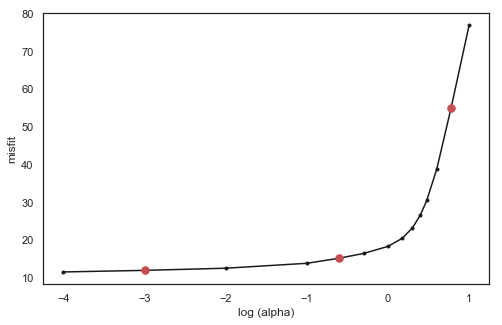

In [6]:
plt.figure(figsize=(8,5))
plt.plot(np.log10(alpha_vec),misfit_vec,'k.-')
plt.plot(np.log10(np.take(alpha_vec,idx)),np.take(misfit_vec,idx),'r.',markersize=15)
plt.xlabel('log (alpha)')
plt.ylabel('misfit')
plt.show()

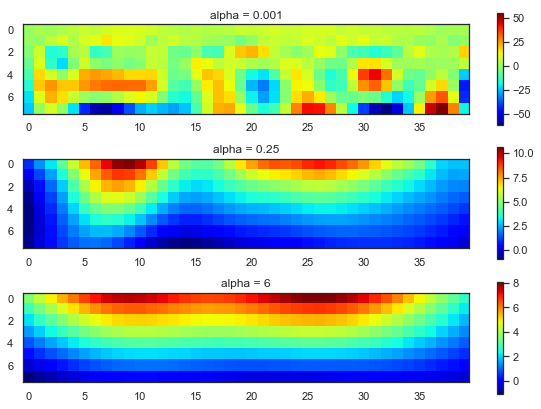

In [7]:
plt.figure(figsize=(10,7))

for i in range(3):
    alpha = alpha_vec[idx[i]]
    G_concat = np.vstack((G,alpha*L));
    m = np.linalg.lstsq(G_concat, d_concat, rcond=None)[0]
    m_ = np.reshape(m,(40,8)).T
    
    plt.subplot(3,1,i+1)
    plt.imshow(m_,cmap=plt.cm.jet)
    plt.title('alpha = {}'.format(alpha))
    plt.colorbar()
    
plt.show()

## Cross validation method
We introduce the cross validation method commonly used in machine learning into deteriming the hyperparameter value in this particular problem.

In [8]:
rms_train = np.zeros(n)
rms_test = np.zeros(n)

K = 5
for i in range(n):
    alpha = alpha_vec[i]
    
    misfit_train_vec = np.zeros(K)
    misfit_test_vec = np.zeros(K)

    kf = KFold(n_splits=K, random_state=False, shuffle=True)
    j = 0
    for idx_test,idx_train in kf.split(range(6000)):
        d_test = np.take(d,idx_test,axis=0)
        G_test = np.take(G,idx_test,axis=0)

        d_train = np.take(d,idx_train,axis=0)
        G_train = np.take(G,idx_train,axis=0)

        #print('d_test: {}, G_test: {}, d_train: {}, G_train {}'.format(d_test.shape,G_test.shape,d_train.shape,G_train.shape))

        d_concat = np.vstack((d_train,d_pseudo))
        G_concat = np.vstack((G_train,alpha*L))

        m = np.linalg.lstsq(G_concat, d_concat, rcond=None)[0]

        v_train = d_train - np.dot(G_train,m);
        misfit_train_vec[j] = np.dot(v_train.T,v_train)/len(v_train);
        v_test = d_test - np.dot(G_test,m);
        misfit_test_vec[j] = np.dot(v_test.T,v_test)/len(v_test);

        j += 1
    #print('misfit_train_vec: {}, misfit_test_vec: {}'.format(misfit_train_vec,misfit_test_vec))

    rms_train[i] = np.mean(misfit_train_vec)
    rms_test[i] = np.mean(misfit_test_vec)
    #print('rms_train: {}, rms_test: {}'.format(rms_train,rms_test))
    #print('rms_ratio = {}'.format(rms_train/rms_test))
#print('rms_train: {}, rms_test: {}'.format(rms_train,rms_test))

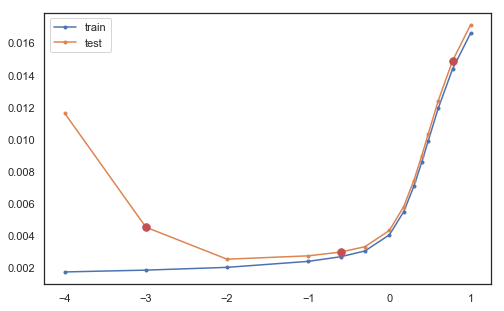

In [9]:
plt.figure(figsize=(8,5))
plt.plot(np.log10(alpha_vec),rms_train,'.-')
plt.plot(np.log10(alpha_vec),rms_test,'.-')
plt.plot(np.log10(np.take(alpha_vec,idx)),np.take(rms_test,idx),'r.',markersize=15)
plt.legend(('train','test'))
plt.show()

### Better test/train splits ?
It might a better idea to divide the whole deformation map into several parts based on the magnitude of the deformation before spliting, instead of just spliting the whole map. 

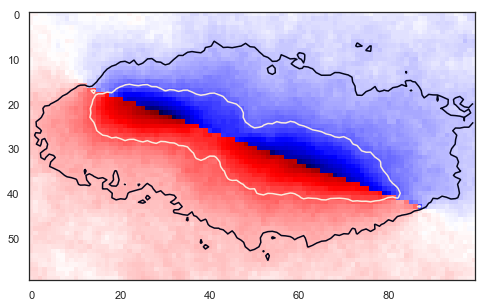

In [11]:
d_mat = np.flipud(np.reshape(d,(100,60)).T)
plt.figure(figsize=(8,6))
plt.imshow(d_mat,cmap=plt.cm.seismic)
#plt.colorbar()
plt.contour(np.abs(d_mat),[0.36,0.9])
plt.show()